In [145]:
# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

from utilities import data_basic_utility as databasic
from utilities import dataframe_utility as dfutil
import features_utility as featutil

## File Details - Content Filtering 2 - Tinkering with features

Adding review counts by beer and by reviewer as features


In [146]:
filePrefix = "A3_061_lgbm_basicregression_review_counts"
baseDataDir = "C:/Development/Data/COSC2670/Assignment3/A3data/"
subrunDir = "subruns/"
writeSubRunFile = True
seed = databasic.get_random_seed()

In [147]:
# RowID  BeerID  ReviewerID  BeerName  BeerType  Label
# df_train = pd.read_csv(baseDataDir + 'train_500k.tsv',sep='\t',
df_train = pd.read_csv(baseDataDir + 'train_200k.tsv',sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])
df_train.head(10)

# df_vali = pd.read_csv(baseDataDir + 'vali_500k.tsv',sep='\t',
df_vali = pd.read_csv(baseDataDir + 'vali_200k.tsv',sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])
df_vali.head(10)


,RowID,BeerID,ReviewerID,BeerName,BeerType,rating
0,22,12300,2634,Rauch �r Bock,Rauchbier,4.0
1,27,12300,5634,Rauch �r Bock,Rauchbier,4.5
2,28,12300,3544,Rauch �r Bock,Rauchbier,4.5
3,40,12300,6521,Rauch �r Bock,Rauchbier,4.0
4,43,12300,10177,Rauch �r Bock,Rauchbier,4.5
5,48,12300,2907,Rauch �r Bock,Rauchbier,3.5
6,49,12300,1532,Rauch �r Bock,Rauchbier,4.0
7,50,12300,3452,Rauch �r Bock,Rauchbier,3.5
8,59,12300,6861,Rauch �r Bock,Rauchbier,4.0
9,64,6699,6401,Caldera Pale Ale,American Pale Ale (APA),4.5


In [148]:
print(df_train.shape)
df_train.sort_values("ReviewerID").head(10)


(120564, 6)


,RowID,BeerID,ReviewerID,BeerName,BeerType,rating
108375,203256,1206,1,1554 Enlightened Black Ale,Belgian Dark Ale,5.0
118455,222600,9573,1,Espresso Oak Aged Yeti Imperial Stout,American Double / Imperial Stout,4.0
113816,214001,1678,1,Sinebrychoff Porter,Baltic Porter,4.0
67826,127577,2225,1,River Horse Special Ale ESB,Extra Special / Strong Bitter (ESB),2.0
16324,31809,2790,1,Founders Centennial IPA,American IPA,4.0
78232,147750,8764,1,Pumking,Pumpkin Ale,4.0
119080,223691,4575,1,Yeti Imperial Stout,Russian Imperial Stout,4.5
97719,183059,3427,1,YuleSmith (Summer),American Double / Imperial IPA,4.0
17289,33484,5859,1,Founders KBS (Kentucky Breakfast Stout),American Double / Imperial Stout,5.0
41842,79153,1623,1,Sierra Nevada Bigfoot Barleywine Style Ale,American Barleywine,3.0


In [149]:
# Tinkering to get it working

# df_train_reviewer_counts = df_train.groupby("ReviewerID", as_index=False).size()
# df_train_reviewer_counts.columns=["ReviewerID", "ReviewerReviewCount"]

# print(type(df_train_reviewer_counts))

# df_train = pd.merge(df_train, df_train_reviewer_counts, how="inner", left_on="ReviewerID", right_on="ReviewerID")
# df_train.head()

# df_train["ReviewerReviewCount"] = df_train.groupby("ReviewerID").size()
# print(df_train.shape)
# df_train.head(20)

In [150]:
df_train = featutil.addReviewerReviewCount(df_train)
df_train = featutil.addBeerReviewCount(df_train)

df_vali = featutil.addReviewerReviewCount(df_vali)
df_vali = featutil.addBeerReviewCount(df_vali)

# df_train.head(10)

In [151]:
# RowID BrewerID ABV DayofWeek Month DayofMonth Year TimeOfDay Gender Birthday Text Lemmatized POS_Tag
# df_features = pd.read_csv(baseDataDir + 'features_500k.tsv',sep='\t', names=['RowID','BrewerID','ABV','DayofWeek','Month',
df_features = pd.read_csv(baseDataDir + 'features_200k.tsv',sep='\t', names=['RowID','BrewerID','ABV','DayofWeek','Month',
                                                                 'DayofMonth','Year','TimeOfDay','Gender',
                                                                 'Birthday','Text','Lemmatized','POS_Tag'])

df_features.head()

,RowID,BrewerID,ABV,DayofWeek,Month,DayofMonth,Year,TimeOfDay,Gender,Birthday,Text,Lemmatized,POS_Tag
0,18,1075,7.4,Mon,Jan,2,2012,15:20:04,Male,unknown,Pours a murky light brown with a 1 inch fizzy ...,pour a murky light brown with a 1 inch fizzy t...,VBZ DT JJ NN JJ IN DT CD NN JJ NN NN WDT VBZ I...
1,19,1075,7.4,Sun,Jan,1,2012,06:46:52,Male,unknown,Faint sudsy head with some with some dissipati...,faint sudsy head with some with some dissipate...,NN JJ NN IN DT IN DT VBG JJ NN . JJ JJ NN . DT...
2,20,1075,7.4,Tue,Nov,29,2011,05:51:44,Male,unknown,A new arrival to the West TN area ... Pours qu...,a new arrival to the West TN area ... pour qui...,"DT JJ NN IN DT NNP NNP NN , VBZ PDT DT NN JJR ..."
3,21,1075,7.4,Sat,Nov,5,2011,22:59:57,Male,unknown,Sampled 10/30/11 - Transferring the notes . A ...,sample 10/30/11 - transfer the note . a ruby p...,VBN CD HYPH VBG DT NNS . DT NN VBP IN DT NN NN...
4,22,1075,7.4,Tue,Nov,1,2011,20:40:21,Male,"Oct 14, 1983",This is my first rauchbier . Pours a burnt amb...,this be my first rauchbier . pour a burn amber...,DT VBZ PRP$ JJ NN . VBZ DT VBN NN . JJ NN . NN...


In [152]:
colsToUse = ["RowID", "BrewerID", "ABV", "DayofWeek", "DayofMonth", "Month", "Year", "Gender", "TimeOfDay"]

# Find the feature records that match the training and validation data and join them together
dfFullData = df_train.join(df_features[colsToUse], on="RowID", how="inner", rsuffix="Feat")
dfFullDataVali = df_vali.join(df_features[colsToUse], on="RowID", how="inner", rsuffix="Feat")

dfFullData.head()

,RowID,BeerID,ReviewerID,BeerName,BeerType,rating,ReviewerReviewCount,BeerReviewCount,RowIDFeat,BrewerID,ABV,DayofWeek,DayofMonth,Month,Year,Gender,TimeOfDay
0,19,12300,10635,Rauch �r Bock,Rauchbier,4.0,36,23,37,1075,7.4,Mon,23,May,2011,Male,15:36:28
1,21,12300,6547,Rauch �r Bock,Rauchbier,4.5,4,23,40,1075,7.4,Mon,16,May,2011,Male,00:31:46
2,23,12300,9789,Rauch �r Bock,Rauchbier,4.5,36,23,42,1075,7.4,Sun,10,Apr,2011,unknown,12:17:26
3,24,12300,7372,Rauch �r Bock,Rauchbier,5.0,69,23,43,1075,7.4,Wed,30,Mar,2011,Male,14:08:00
4,25,12300,1302,Rauch �r Bock,Rauchbier,4.5,59,23,45,1075,7.4,Thu,24,Mar,2011,Male,14:07:00


In [153]:
# Remove the duplicated Row ID, also remove Beer Name at this point, we're nt using it
df_train_data = dfFullData.drop(['RowIDFeat', "BeerName"],axis=1)
df_vali_data = dfFullDataVali.drop(['RowIDFeat', "BeerName"],axis=1)

df_train_data[df_train_data["ReviewerID"] == 9789].head(20)

# df_train_data.head()

,RowID,BeerID,ReviewerID,BeerType,rating,ReviewerReviewCount,BeerReviewCount,BrewerID,ABV,DayofWeek,DayofMonth,Month,Year,Gender,TimeOfDay
2,23,12300,9789,Rauchbier,4.5,36,23,1075,7.4,Sun,10,Apr,2011,unknown,12:17:26
1140,23558,4522,9789,American Double / Imperial Stout,4.5,36,1399,1199,6.6,Sun,27,May,2007,Male,11:25:00
5229,142845,10201,9789,Russian Imperial Stout,4.5,36,179,3818,9.6,Wed,30,Sep,2009,Male,05:20:51
8844,11869,5432,9789,Irish Dry Stout,4.0,36,13,14,4.4,Thu,12,Aug,2010,Male,05:31:59
8857,11912,10517,9789,Saison / Farmhouse Ale,4.0,36,21,14,9.0,Wed,20,Oct,2004,Male,20:35:50
8878,12018,6736,9789,American Pale Ale (APA),4.5,36,81,14,6.0,Fri,29,Apr,2011,Male,12:10:55
8959,12195,6180,9789,American Porter,4.0,36,26,14,11.5,Wed,21,Jan,2004,Male,05:36:24
8985,12389,11181,9789,American Porter,4.0,36,81,1199,10.6,Sun,16,Oct,2011,Male,05:42:11
9066,12506,6041,9789,American Brown Ale,4.0,36,77,1199,10.6,Fri,21,Jan,2011,unknown,14:54:28
9143,18740,8188,9789,Scotch Ale / Wee Heavy,4.0,36,568,1199,8.3,Wed,12,Oct,2011,unknown,11:38:05


In [154]:

df_train_data[df_train_data["BeerID"] == 5947].head(20)

,RowID,BeerID,ReviewerID,BeerType,rating,ReviewerReviewCount,BeerReviewCount,BrewerID,ABV,DayofWeek,DayofMonth,Month,Year,Gender,TimeOfDay
10659,50891,5947,9789,American Double / Imperial IPA,4.0,36,415,16866,18.2,Mon,28,Nov,2011,Male,10:26:56
10660,51220,5947,850,American Double / Imperial IPA,2.5,162,415,16866,10.5,Sun,18,Oct,2009,Male,14:01:26
10661,51171,5947,2962,American Double / Imperial IPA,4.5,146,415,16866,10.5,Sun,29,Nov,2009,Male,15:39:59
10662,51391,5947,7207,American Double / Imperial IPA,4.0,379,415,16866,11.0,Fri,7,Aug,2009,Male,13:52:45
10663,51363,5947,7162,American Double / Imperial IPA,4.0,124,415,16866,10.5,Wed,28,Sep,2011,Male,13:38:01
10664,51133,5947,4767,American Double / Imperial IPA,4.5,81,415,16866,10.5,Thu,11,Feb,2010,Male,02:56:11
10665,50866,5947,2359,American Double / Imperial IPA,4.0,113,415,16866,18.2,Sun,2,Aug,2009,Male,16:53:42
10666,51239,5947,6886,American Double / Imperial IPA,5.0,72,415,16866,10.5,Wed,7,Oct,2009,Male,12:09:12
10667,51183,5947,1925,American Double / Imperial IPA,4.0,23,415,16866,10.5,Thu,26,Nov,2009,Male,11:44:42
10668,51156,5947,3544,American Double / Imperial IPA,5.0,117,415,16866,10.5,Sun,6,Dec,2009,Male,14:14:06


In [155]:

df_train_data[["ReviewerID", "ReviewerReviewCount"]].sort_values("ReviewerID").drop_duplicates().head(20)

,ReviewerID,ReviewerReviewCount
88602,1,33
100573,2,19
42592,4,12
70094,5,2
93983,7,19
71859,8,2
28313,9,6
118366,10,1
38848,11,3
41227,14,19


In [156]:

df_train_data[["BeerID", "BeerReviewCount"]].sort_values("BeerID").drop_duplicates().head(20)

,BeerID,BeerReviewCount
95557,1,7
110160,8,45
114100,9,47
113686,10,47
108776,61,155
96524,62,122
104561,63,117
86642,122,43
109224,123,70
82587,124,54


In [157]:
print(df_train_data.shape)
print(df_vali_data.shape)

(106546, 15)
(35089, 15)


In [158]:
colsToUse.append("BeerType")
colsToUse.append("ReviewerReviewCount")
colsToUse.append("BeerReviewCount")

considerCol = {}

# Initialize them all to True, use all the cols
for colName in colsToUse:
  considerCol[colName] = True

# "RowID", "BrewerID", "BeerType", "ABV", "DayofWeek", "DayofMonth", "Month", "Year", "Gender", "TimeOfDay"
# Disable any column we want

# Usually always include year
# considerCol["Year"] = False

# Beer Context Columns
considerCol["ABV"] = False
considerCol["BrewerID"] = False
considerCol["BeerType"] = False

# Consumer Context Columns
# considerCol["DayofWeek"] = False
# considerCol["DayofMonth"] = False
# considerCol["Month"] = False
# considerCol["TimeOfDay"] = False
# considerCol["Gender"] = False

# Review Count Columns
# considerCol["ReviewerReviewCount"] = False
# considerCol["BeerReviewCount"] = False

In [159]:
if considerCol["ABV"] == False:
  del df_train_data["ABV"]
  del df_vali_data["ABV"]

In [160]:
if considerCol["BrewerID"] == False:
  del df_train_data["BrewerID"]
  del df_vali_data["BrewerID"]
else: 
  df_train_data, df_vali_data = dfutil.getDummiesForSplitSets(df_train_data, df_vali_data, "BrewerID")


In [161]:
if considerCol["BeerType"] == False:
  del df_train_data["BeerType"]
  del df_vali_data["BeerType"]
else: 
  df_train_data, df_vali_data = dfutil.getDummiesForSplitSets(df_train_data, df_vali_data, "BeerType")

In [162]:
if considerCol["Gender"] == False:
  del df_train_data["Gender"]
  del df_vali_data["Gender"]
else: 
  df_train_data, df_vali_data = dfutil.getDummiesForSplitSets(df_train_data, df_vali_data, "Gender")

c:\Development\COSC2670\Assignment3\utilities\dataframe_utility.py:27: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_combined.columns = df_combined.columns.str.replace(" ", "").str.replace("/", "").str.replace("-", "") \


In [163]:
if considerCol["DayofWeek"] == False:
  del df_train_data["DayofWeek"]
  del df_vali_data["DayofWeek"]
else: 
  df_train_data = featutil.formatDayOfWeek(df_train_data)
  df_vali_data = featutil.formatDayOfWeek(df_vali_data)

In [164]:
if considerCol["Month"] == False:
  del df_train_data["Month"]
  del df_vali_data["Month"]
else: 
  df_train_data = featutil.formatMonth(df_train_data)
  df_vali_data = featutil.formatMonth(df_vali_data)

In [165]:
if considerCol["DayofMonth"] == False:
  del df_train_data["DayofMonth"]
  del df_vali_data["DayofMonth"]

In [166]:
if considerCol["Year"] == False:
  del df_train_data["Year"]
  del df_vali_data["Year"]

In [167]:
if considerCol["TimeOfDay"] == False:
  del df_train_data["TimeOfDay"]
  del df_vali_data["TimeOfDay"]
else: 
  df_train_data = featutil.formatTimeToSec(df_train_data)
  df_vali_data = featutil.formatTimeToSec(df_vali_data)

In [168]:
if considerCol["ReviewerReviewCount"] == False:
  del df_train_data["ReviewerReviewCount"]
  del df_vali_data["ReviewerReviewCount"]

In [169]:
if considerCol["BeerReviewCount"] == False:
  del df_train_data["BeerReviewCount"]
  del df_vali_data["BeerReviewCount"]

In [170]:
print(df_train_data.shape)
print(df_vali_data.shape)

df_train_data.head()

(106546, 14)
(106546, 14)


,RowID,BeerID,ReviewerID,rating,ReviewerReviewCount,BeerReviewCount,DayofWeek,DayofMonth,Month,Year,TimeOfDay,Gender_Female,Gender_Male,Gender_unknown
0,19,12300,10635,4.0,36,23,1,23,5,2011,56188,0,1,0
1,21,12300,6547,4.5,4,23,1,16,5,2011,1906,0,1,0
2,23,12300,9789,4.5,36,23,7,10,4,2011,44246,0,0,1
3,24,12300,7372,5.0,69,23,3,30,3,2011,50880,0,1,0
4,25,12300,1302,4.5,59,23,4,24,3,2011,50820,0,1,0


In [171]:
df_vali_data.head()

,RowID,BeerID,ReviewerID,rating,ReviewerReviewCount,BeerReviewCount,DayofWeek,DayofMonth,Month,Year,TimeOfDay,Gender_Female,Gender_Male,Gender_unknown
0,19,12300,10635,4.0,36,23,1,23,5,2011,56188,0,1,0
1,21,12300,6547,4.5,4,23,1,16,5,2011,1906,0,1,0
2,23,12300,9789,4.5,36,23,7,10,4,2011,44246,0,0,1
3,24,12300,7372,5.0,69,23,3,30,3,2011,50880,0,1,0
4,25,12300,1302,4.5,59,23,4,24,3,2011,50820,0,1,0


In [172]:
# free up the memory
del dfFullData
del dfFullDataVali

In [173]:
# Get all the columns
col_names = df_train_data.columns

idCols = ['RowID','BeerID','ReviewerID']
feature_cols =  col_names.drop(['RowID','BeerID','ReviewerID','rating' ])
target_col = 'rating'

# Create the sub data sets of the features and the target
dfTrainIds = df_train_data[idCols]
dfTrainFeatures = df_train_data[feature_cols]
dfTrainTarget = df_train_data[target_col]

dfValiIds = df_vali_data[idCols]
dfValiFeatures = df_vali_data[feature_cols]
dfValiTarget = df_vali_data[target_col]


In [174]:
print(dfTrainFeatures.shape)
dfTrainFeatures.head()

(106546, 10)


,ReviewerReviewCount,BeerReviewCount,DayofWeek,DayofMonth,Month,Year,TimeOfDay,Gender_Female,Gender_Male,Gender_unknown
0,36,23,1,23,5,2011,56188,0,1,0
1,4,23,1,16,5,2011,1906,0,1,0
2,36,23,7,10,4,2011,44246,0,0,1
3,69,23,3,30,3,2011,50880,0,1,0
4,59,23,4,24,3,2011,50820,0,1,0


In [175]:

# Create the Light GBM Regression model and train
model = lgb.LGBMRegressor(objective="regression_l1", metric="mae"
    ,random_state=seed)
    
model.fit(X=dfTrainFeatures, y=dfTrainTarget, )

LGBMRegressor(metric='mae', objective='regression_l1', random_state=184503)

In [176]:
# Use the model to predict against our validation data
test_predicted = model.predict(dfValiFeatures)
test_predicted[0:100]

array([4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  ,
       4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  ,
       4.  , 4.05, 4.  , 4.  , 4.05, 4.  , 4.  , 4.  , 4.  , 4.  , 4.05,
       4.  , 4.  , 4.  , 4.05, 4.05, 4.05, 4.05, 4.  , 4.  , 4.  , 4.  ,
       4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.05, 4.  , 4.05, 4.  , 4.  ,
       4.05, 4.  , 4.  , 4.  , 4.05, 4.  , 4.  , 4.  , 4.  , 4.05, 4.  ,
       4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.  ,
       4.  , 4.05, 4.  , 4.  , 4.05, 4.05, 4.05, 4.05, 4.05, 4.  , 4.05,
       4.05, 4.05, 4.  , 4.  , 4.  , 4.  , 4.  , 4.  , 4.05, 4.  , 4.  ,
       4.  ])

<AxesSubplot:>

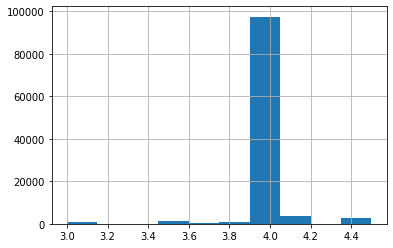

In [177]:
dfPredicted = pd.DataFrame({"Predict": test_predicted})
dfPredicted['Predict'].hist(bins=10)


In [178]:
mae = mean_absolute_error(dfValiTarget, test_predicted)

print("Average MAE: " + str(mae))
print("analyse_maes.append(" + str(mae) + ")")

Average MAE: 0.453666796514198
analyse_maes.append(0.453666796514198)


In [179]:

# print("Run: " + filePrefix)
# # Log of Results
# analyse_maes = []

# print("Average MAE over all tests: " + str(np.mean(analyse_maes)))

# Make sure it's predicting floats
# dfPredicted["Predict"].drop_duplicates()

# Results of Runs

Including Review Count columns
* All Columns:
* Beer context (Inc ABV):  0.4437125111643793
* Beer Context no ABV: 0.4446008288780617
* Beer context (Inc ABV and Year): 0.44370481859591127
* Consumer Context: 0.453666796514198

## From Feats Tinker, before adding ReviewCounts Cols

File: 200k
Possible Columns: BreweryID, ABV, Beer Type, DayOfWeek, Month, Year, Time of Day (in sec), Gender

These are all without DayofMonth
* ABV, Beer Type (From Basic Regression) MAE: 0.44852097367102955
* All Cols except brewer: 0.4483903262744929
* All Cols minus brewer and beer type: 0.4620847607915829
* All Cols: 0.44561029386667883
* Just Brewery, Year and Beer Type:  0.44538233646964837
* Just Brewery, Year, Beer Type and ABV: 0.44561029386667883
* Just Brewery and Beer Type:  0.44538233646964837

Added DayOfMonth
* All Columns: 0.44561029386667883
* Beer context + ABV (Brewery, Beer Type, ABV) : 0.44561029386667883
* Beer Context Brewery and Beer Type:  0.44538233646964837
* Consumer Context (DayOfWeek, Month, Year, Time of Day (in sec), Gender): 0.46286486587952613

File: 500k (no DayofMonth
* All Cols: 0.4656715581037993
* Just Brewery, Year, Beer Type and ABV: 0.4656715581037993
Exactly the same? weird


Write to a subrun file

In [180]:
dfPredicted = pd.concat([dfValiIds.reset_index(), dfPredicted], axis=1).drop(columns="index")

if writeSubRunFile:
  dfPredicted.to_csv(subrunDir + filePrefix + "_subrun.csv", index=False)

print("Average MAE: " + str(mae))
print(dfPredicted.shape)
dfPredicted.sort_values("RowID").head(20)


Average MAE: 0.453666796514198
(106546, 4)


,RowID,BeerID,ReviewerID,Predict
0,19,12300,10635,4.0
1,21,12300,6547,4.0
2,23,12300,9789,4.0
3,24,12300,7372,4.0
4,25,12300,1302,4.0
5,26,12300,704,4.0
6,29,12300,1747,4.0
7,31,12300,9368,4.0
8,32,12300,2568,4.0
9,33,12300,6838,4.0
